# Многослойный перцептрон

В этом блокноте мы реализуем возможность построения полносвязной многослойной нейронной сети при помощи `numpy`. Сначала загрузим требующиеся библиотеки.

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import numpy as np

## Немного про то, как действуют слои

На данный момент мы намеренно не будем расширять матрицу входных данных значениями $-1$, как мы это делали в однослойной сети, и опишем действие слоя нейронной сети несколько иначе. 

Пусть нам дан на вход некоторый набор данных $X$ размера $[n \times p]$, состоящий из $n$ объектов, каждый из которых характеризуется $p$ фичами. Действие любого скрытого слоя нейронной сети можно разбить на два этапа. Первый этап — это действие сумматора, производится оно следующим образом:
$$
Y_1 = X\cdot W_0 - b_0,
$$
где $W_0$ — матрица размера $[p \times n_1]$, где $n_1$ — количество нейронов следующего слоя, $b_0$ — вектор смещений каждого нейрона (по сути — матрица размера $[n \times n_1]$, чьи элементы, находящиеся в одном столбце, одинаковы). Итого, на выходе мы получаем для каждого объекта $n_1$ новый признак. Но это не все, второй этап — применение некоторой функции активации $\varphi_0$ поэлементно ко всем элементам матрицы $Y_1$, полученной этапом ранее:
$$
Z_1 = \varphi_0(Y_1).
$$
Полученная матрица и является входной матрицей для следующего слоя нейронов. 

Таким образом, имея $(k - 1)$ построенный слой, мы можем построить $k$-ый слой при помощи двух операций:
$$
Y_k = Z_{k - 1}W_{k-1} - b_{k-1}, \quad Z_k = \varphi_{k-1}(Y_k).
$$
Последний слой обычно выделяют особо, так как этот слой — выходной, и в зависимости от решаемой задачи его выход может разниться. 

## Выходной слой при классификации

Мы, опять-таки, будем решать задачу классификации, так что введем еще раз уже известные обозначения.

Пусть
$$
x_i = (x_i^1, ..., x_i^{p}), \quad i \in \{1, 2, ..., n\},
$$
— $i$-ый тренировочный объект, $y_i$ — числовая метка класса $i$-ого объекта,
$$
w^j = (w_1^j, ..., w_{p}^j)^T, \quad j \in \{1, 2, ..., m\},
$$
— веса $j$-ого нейрона — столбцы матрицы $W$, $b^j$ — смещение $j$-ого нейрона — столбцы матрицы $b$.

Напишем интересующую нас функцию потерь, $y = \{y_1, ..., y_n\}$:
$$
Loss(X, W, y) = -\frac{1}{n} \sum\limits_{i = 1}^n \ln \frac{\exp(x_i \cdot w^{y_i} - b^{y_i})}{\sum\limits_{j = 1}^m\exp(x_i \cdot w^j - b^j)} + \lambda R(w) = -\frac{1}{n}\sum\limits_{i = 1}^n \left((x_i \cdot w^{y_i} - b^{y_i}) - \ln \sum\limits_{j = 1}^m\exp(x_i \cdot w^j - b^j)\right) + \lambda  R(w),
$$
где 
$$
x_i \cdot w^j = \sum\limits_{k = 1}^px_i^kw^j_k
$$
— скалярное произведение соответсвующих векторов.

Для обучения сети нам понадобится градиент этой функции, вычислим его.
$$
\frac{\partial Loss(X, W, y)}{\partial w^{y'}_p} = -\frac{1}{n} \sum\limits_{i = 1}^n \left( x_i^p[y_i = y'] - x_i^p \frac{exp(x_i \cdot w^{y'})}{\sum\limits_{j = 1}^m \exp(x_i \cdot w^j)}\right) + \lambda  \frac{\partial R}{\partial w}.
$$
В таком виде градиент использовать неудобно и вычислительно неэффективно. Можно заметить, что в матричном виде он переписывается следующим образом:
$$
\frac{\partial Loss(X, W, y)}{\partial w} = -\frac{1}{n}X^T\left(M - P\right) + \lambda \frac{\partial R}{\partial w}.
$$
Поясним входящие в последнее выражение объекты.  Как мы уже отметили, до применения функции активации выходы нейронов после «сумматора» для набора данных $X$ могут быть получены следущим образом:
$$
Outs = X \cdot W - b.
$$
Матрица $Outs$ имеет размер $[n \times m]$ и построчно содержит значения выходов каждого из $m$ нейронов для соответсвующего объекта подаваемых данных. Тогда матрица $P$ — это матрица `softmax`-ов для каждого нейрона, на пересечении $i$-ой строки и $t$-ого столбца которой стоят значения
$$
\frac{\exp(x_i \cdot w^t)}{\sum\limits_{j = 1}^m \exp(x_i \cdot w^j)}, \quad i \in \{1, 2, ..., n\}, \quad t \in \{1, 2, ..., m\},
$$
$M$ — матрица размера $[n \times m]$ — разреженная матрица `one_hot` кодированных откликов. 

## Снова про регуляризацию



Теперь про регуляризацию. В случае $l_p$, $p \in \{1, 2\}$, регуляризатор имеет вид:
$$
R_p(W) = \sum\limits_{i = 1}^p\sum\limits_{j = 1}^m |w_i^j|^p,
$$
поэтому в матричном виде производная (или градиент) может быть записана так:
$$
\frac{\partial R_2}{\partial w} = 2\lambda W, \quad \frac{\partial R_1}{\partial \omega} = \lambda \operatorname{sign}W.
$$

## Теперь о матричном дифференцировании

Матричные операции очень неплохо реализованы в питоне, поэтому именно им и стоит отдать предпочтение при реализации шага градиентного спуска для поиска параметров слоев. Мы уже поняли, что если выходы последнего слоя завязаны на функции потерь, описанной выше, то 
$$
\frac{\partial Loss(X, W, y)}{\partial w} = -\frac{1}{n}X^T\left(M - P\right) + \lambda \frac{\partial R}{\partial w}.
$$
Это реализовано в `__get_grad`. В общем случае,
$$
Z = \varphi(XW - b), \quad \frac{\partial Z}{\partial W} = X^T\frac{\partial(\varphi(XW - b))}{\partial(XW - b)}, \quad \frac{\partial Z}{db} = - \frac{\partial(\varphi(XW - b))}{\partial(XW - b)}.
$$
Немного деликатнее оказывается вопрос вычисления более «глубоких» производных, ведь параметры предыдущих слоев находятся внутри $X$, а $X$ получается в результате применения функции активации предыдущего слоя. Поятно, что если
$$
X = \psi(\widetilde X \widetilde W - \widetilde b),
$$
то
$$
\frac{\partial Z}{\partial \widetilde W} = \widetilde X^T\left(\left(\frac{\partial(\varphi(XW - b))}{\partial(XW - b)} W^T\right) \odot \frac{\partial \psi(X \widetilde W - \widetilde b)}{\partial (X \widetilde W - \widetilde b)}\right),
$$
и так далее. Это правило цепочки реализовано в самом конце метода `fit`.

## Программная реализация и тесты

In [21]:
class FullyConnectedNetwork:
    __REGULARIZATION_GRAD = {None: lambda _w: 0, "l1": lambda _w: np.sign(_w), "l2": lambda _w: 2*_w}
    __REGULARIZATION_FUNC = {None: lambda _w: 0, "l1": lambda _w: np.abs(_w), "l2": lambda _w: _w ** 2}
    __LOSS = 0
    # создание нейронной сети: alpha — скорость обучения (шаг градиентного спуска), reg_type — тип регуляризации (если есть), lambda — параметр регуляризации; слои будут храниться в списке layers
    def __init__(self, alpha=0.01, reg_type=None, lambda_=0):
        self.__layers = list()
        self.__alpha = alpha
        self.__reg_type = reg_type
        self.__lambda = lambda_

    # метод, позволяющий добавить новый слой: указываем правильные размеры слоя, название функции активации, class_number — количество классов в случае использования Sotmax'а на последнем слое, параметр a — параметр LeakyReLU
    def add_layer(self, size: tuple, activation_func: str, class_number=0, a=0):
        if not self.__layers or self.__layers[-1].size[1] == size[0]:
            self.__layers.append(FullyConnectedLayer(size, activation_func, class_number, a))
        else:
            raise Exception("Wrong size of the layer!")

    def change_alpha(self, alpha):
        self.__alpha = alpha

    def get_loss(self):
        return FullyConnectedNetwork.__LOSS

    # метод, выдающий предсказания для заданного набора данных после обучения модели
    def predict(self, data):
        current_output = data
        for layer in self.__layers[:-1]:
            current_output, _ = layer.forward(current_output, None)
        # отдельно обрабатываем последний слой
        layer_weights, layer_biases = self.__layers[-1].get_weights()
        current_output = np.matmul(current_output, layer_weights) - layer_biases
        _exp_outputs = np.exp(current_output - np.amax(current_output))
        answ = np.transpose(np.transpose(_exp_outputs) / np.sum(_exp_outputs, axis=1))
        return np.array([np.argmax(_row) for _row in answ])

    def score(self, data, answers):
        return (self.predict(data) == answers).sum() / len(answers)

    def fit(self, data, answers):
        # выход входного слоя совпадает с фичами входных данных
        layer_outputs = [data]
        current_output = layer_outputs[0]
        grads = []
        # forward pass и вычисление градиентов функций активации
        for layer in self.__layers:
            current_output, gradient = layer.forward(current_output, answers)
            layer_outputs.append(current_output)
            grads.append(gradient)
        # для вычисления градиентов по правилу цепочки, удобно развернуть массив
        grads = grads[::-1]
        # для градиента параметров самого первого слоя, умножаем на «производную» независимой переменной
        grads.append(1)
        current_gradient = grads[0]
        FullyConnectedNetwork.__LOSS = layer_outputs[-1]
        for i, layer in enumerate(self.__layers[::-1]):
            layer_weights, layer_biases = layer.get_weights()
            FullyConnectedNetwork.__LOSS += self.__lambda * (np.sum(FullyConnectedNetwork.__REGULARIZATION_FUNC[self.__reg_type](layer_weights) + FullyConnectedNetwork.__REGULARIZATION_FUNC[self.__reg_type](layer_biases)))
            # вычисление градиента параметров W слоя layer
            d_weights = np.matmul(layer_outputs[-2 - i].T, current_gradient)
            # вычисление градиента параметров db слоя layer
            d_bias = -np.matmul(np.ones(layer_outputs[-2 - i].shape[0]), current_gradient) / layer_outputs[-2 - i].shape[0]
            # выполнение шага градиентного спуска
            layer.update_weights(self.__alpha * (d_weights + self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer_weights)) , self.__alpha * (d_bias + self.__lambda * FullyConnectedNetwork.__REGULARIZATION_GRAD[self.__reg_type](layer_biases)))
            # правило цепочки
            current_gradient = np.matmul(current_gradient, layer_weights.T) * grads[i + 1]

    # метод для отрисовки весов, первый параметр должен быть квадратом целого числа
    def print_weights(self, label="No label"):
        for layer in self.__layers:
            _pixel_weights, _bias = layer.get_weights()
            size = tuple([int(round((_pixel_weights.shape[0] - 1) ** 0.5)) for _ in range(2)])
            fig, axes = plt.subplots(ncols=5, nrows=2)
            fig.set_size_inches(20, 10)
            for j in range(10):
                axes[j // 5, j % 5].imshow((_pixel_weights[:, j]).reshape(size), cmap=plt.cm.gray, label=label)

# класс, отвечающий за слой в нейронной сети
class FullyConnectedLayer:
    # мы предполагаем, что реализованы следующие функции активации, на последнем слое возможно решение задачи классификации с Softmax
    __ACTIVATION_FUNCTIONS = {'ReLU': {'func': lambda a, x: np.maximum(x, 0), 'derivative': lambda a, x: np.where(x >= 0, 1, 0)},
                              'LReLU': {'func': lambda a, x: np.where(x >= 0, x, a*x), 'derivative': lambda a, x: np.where(x >= 0, 1, a)},
                              'None': {'func': lambda a, x: x, 'derivative': lambda a, x: 1},
                              'Sigmoid': {'func': lambda a, x: np.exp(x) / (1 + np.exp(x)), 'derivative': lambda a, x: np.exp(x) / (1 + np.exp(x)) ** 2},
                              'Softmax': {}}
    # создание нового слоя: задание размеров слоя, случайная (равномерная на [-1/2, 1/2]) инициализация весов, запоминание функции активации, фиксация количества классов в случае решения задачи классификации
    def __init__(self, size: tuple, activation_func: str, class_number=0, a=0):
        self.size = size
        self.__weights = np.random.random((size[0], size[1])) - 0.5
        self.__bias = np.random.random((1, size[1])) - 0.5
        self.__a = a
        if activation_func in FullyConnectedLayer.__ACTIVATION_FUNCTIONS.keys():
            self.__activation_func = activation_func
        else:
            raise Exception("No such activation function!")
        if activation_func == 'Softmax':
            self.__class_number = class_number

    # метод, возвращающий значения весов: веса и смещения
    def get_weights(self):
        return self.__weights, self.__bias

    # метод, модифицирующий веса после градиентного шага
    def update_weights(self, d_weights, d_biases):
        self.__weights -= d_weights
        self.__bias -= d_biases

    # метод, возвращающий градиент
    def __get_grad(self, data, answers):
        if self.__activation_func == 'Softmax':
            return - (self.__one_hot(answers) - self.__get_probabilities(data)) / len(answers)
        else:
            return FullyConnectedLayer.__ACTIVATION_FUNCTIONS[self.__activation_func]['derivative'](self.__a, data)

    # one-hot encoding меток класса
    def __one_hot(self, answers):
        one_hot_answers = np.zeros((len(answers), self.__class_number))
        one_hot_answers[np.arange(len(answers)), answers] = 1
        return one_hot_answers

    # метод, возвращающий вероятности после Softmax'a
    def __get_probabilities(self, data):
        _outputs = np.matmul(data, self.__weights) - self.__bias
        _gamma = np.amax(_outputs)
        _exp_outputs = np.exp(_outputs - _gamma)
        return np.transpose(np.transpose(_exp_outputs) / np.sum(_exp_outputs, axis=1))

    # проход по слою с вычислением градиента функции активации на текущей итерации и текущем наборе данных, для последнего слоя нет нужды вычислять значение, если только не хочется узнать что-то про функцию потерь
    def forward(self, data, answers):
        if self.__activation_func == 'Softmax':
            matrix_pass = np.matmul(data, self.__weights) - self.__bias
            activation = - np.sum(matrix_pass * self.__one_hot(answers) - np.log(np.sum(np.exp(matrix_pass)))) / len(answers)
            gradient = self.__get_grad(data, answers)
        else:
            matrix_pass = np.matmul(data, self.__weights) - self.__bias
            activation = FullyConnectedLayer.__ACTIVATION_FUNCTIONS[self.__activation_func]['func'](self.__a, matrix_pass)
            gradient = self.__get_grad(matrix_pass, answers)
        return activation, gradient

In [5]:
mnist_dataset = datasets.load_digits()

In [6]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(mnist_dataset.data, mnist_dataset.target,
                                                                            test_size=0.2)
X_train_small /= 16
X_test_small /= 16

Training accuracy:  0.9401530967292971 Test accuracy: 0.9138888888888889 Current loss: (99, 124.20954850045165)
Training accuracy:  0.9436325678496869 Test accuracy: 0.9166666666666666 Current loss: (199, 125.73248561702401)
Training accuracy:  0.9436325678496869 Test accuracy: 0.9166666666666666 Current loss: (299, 125.87516082589381)
Training accuracy:  0.9436325678496869 Test accuracy: 0.9166666666666666 Current loss: (399, 125.88933916422754)
Training accuracy:  0.9436325678496869 Test accuracy: 0.9166666666666666 Current loss: (499, 125.89075408078058)
Training accuracy:  0.9436325678496869 Test accuracy: 0.9166666666666666 Current loss: (599, 125.89089558417385)
Training accuracy:  0.9436325678496869 Test accuracy: 0.9166666666666666 Current loss: (699, 125.89090973438098)
Training accuracy:  0.9436325678496869 Test accuracy: 0.9166666666666666 Current loss: (799, 125.89091114942033)
Training accuracy:  0.9436325678496869 Test accuracy: 0.9166666666666666 Current loss: (899, 125.

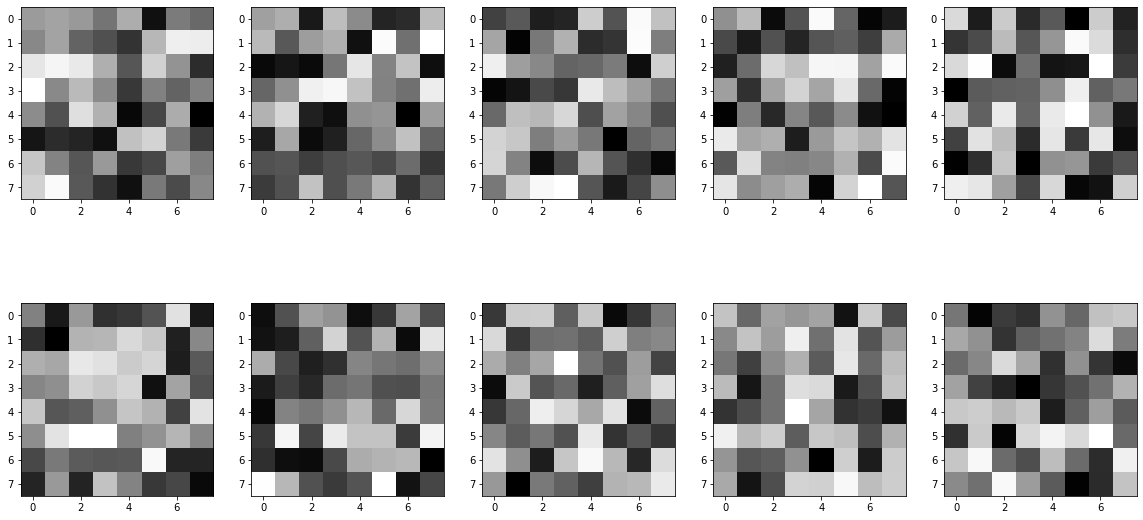

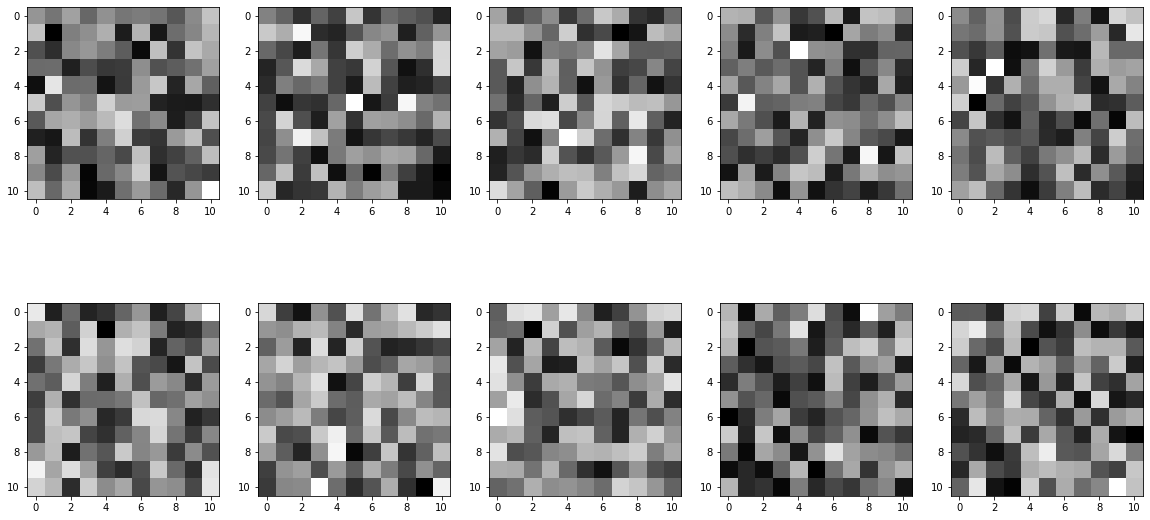

In [24]:
NN = FullyConnectedNetwork(alpha=0.1, reg_type='l2', lambda_=0.002)
loss = []
NN.add_layer((64, 121), 'ReLU')
NN.add_layer((121, 10), 'Softmax', class_number=10)
alpha = 0.1
for ep in range(5000):
    NN.fit(X_train_small, y_train_small)
    loss.append((ep, NN.get_loss()))
    if (ep + 1) % 100 == 0:
        alpha = alpha / 10
        NN.change_alpha(alpha)
        print('Training accuracy: ', NN.score(X_train_small, y_train_small), 'Test accuracy:', NN.score(X_test_small, y_test_small), 'Current loss:', loss[-1])
NN.print_weights()

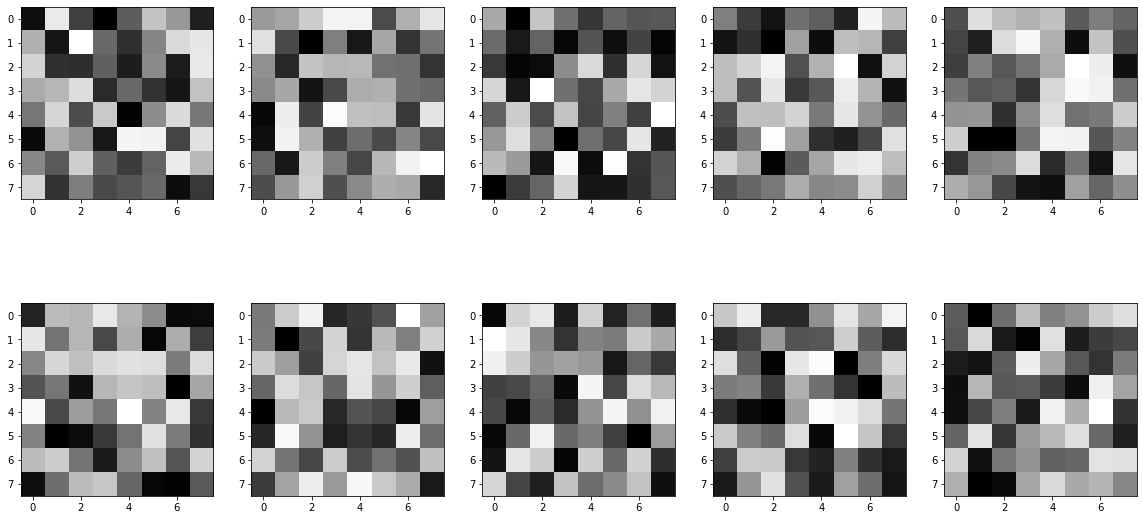

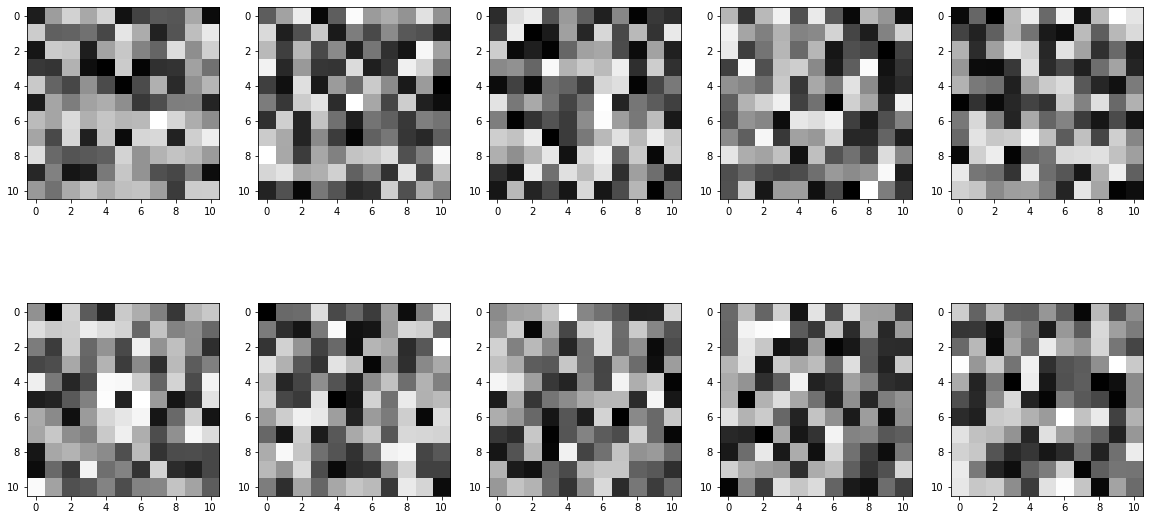

In [17]:
NN.print_weights()

In [25]:
from keras.datasets import mnist

In [26]:
(X_train_big, y_train_big), (X_test_big, y_test_big) = mnist.load_data()

X_train_big = X_train_big.reshape(-1, 784).astype("float32") / 255
X_test_big = X_test_big.reshape(-1, 784).astype("float32") / 255

In [15]:
NN = FullyConnectedNetwork(alpha=0.01, reg_type='l2', lambda_=0.2)
NN.add_layer((784, 10), 'Softmax', class_number=10)

Training accuracy:  0.44448333333333334 Test accuracy: 0.4559 Current loss: (99, 182.00510634373325)
Training accuracy:  0.6292166666666666 Test accuracy: 0.6445 Current loss: (199, 155.76137988063806)
Training accuracy:  0.7345166666666667 Test accuracy: 0.7502 Current loss: (299, 144.26201224837135)
Training accuracy:  0.7848333333333334 Test accuracy: 0.796 Current loss: (399, 139.2056083911176)
Training accuracy:  0.80565 Test accuracy: 0.8176 Current loss: (499, 136.98443101840522)
Training accuracy:  0.8149 Test accuracy: 0.8235 Current loss: (599, 136.0134890079829)
Training accuracy:  0.8181666666666667 Test accuracy: 0.8277 Current loss: (699, 135.5930759537935)
Training accuracy:  0.8199 Test accuracy: 0.8307 Current loss: (799, 135.4139656719583)
Training accuracy:  0.8205666666666667 Test accuracy: 0.8318 Current loss: (899, 135.3397221309536)
Training accuracy:  0.8207833333333333 Test accuracy: 0.8318 Current loss: (999, 135.31040499693168)
CPU times: user 29min 50s, sys:

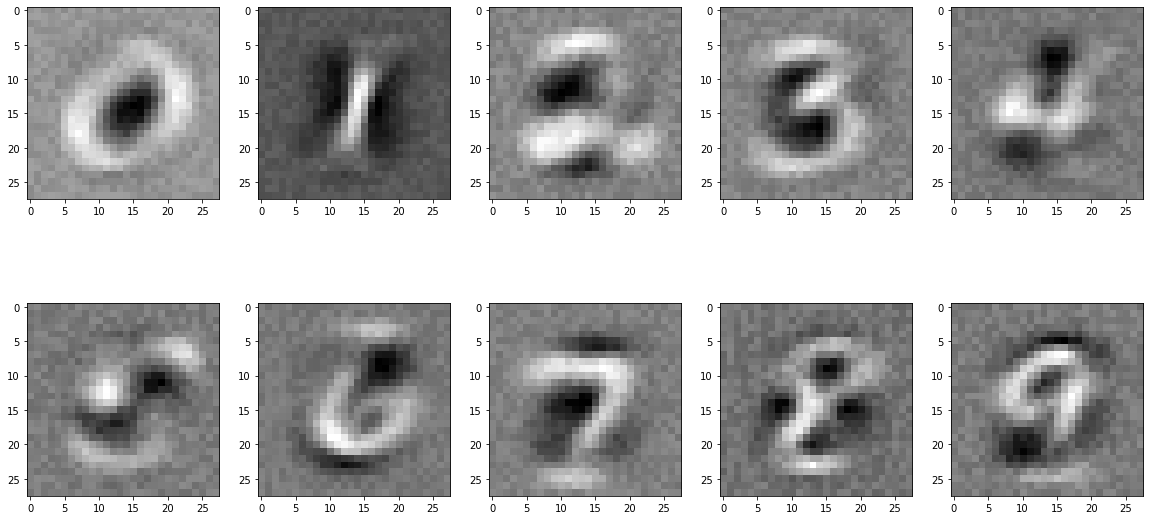

In [17]:
%%time
loss = []
for ep in range(1000):
    NN.fit(X_train_big, y_train_big)
    loss.append((ep, NN.get_loss()))
    if (ep + 1) % 100 == 0:
        print('Training accuracy: ', NN.score(X_train_big, y_train_big), 'Test accuracy:', NN.score(X_test_big, y_test_big), 'Current loss:', loss[-1])
NN.print_weights()

In [18]:
NN = FullyConnectedNetwork(alpha=0.01, reg_type='l2', lambda_=0.2)
NN.add_layer((784, 10), 'Softmax', class_number=10)

Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (99, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (199, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (299, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (399, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (499, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (599, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (699, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (799, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (899, 89.37626552763093)
Training accuracy:  0.8214833333333333 Test accuracy: 0.8314 Current loss: (999, 89.37626552763093)
C

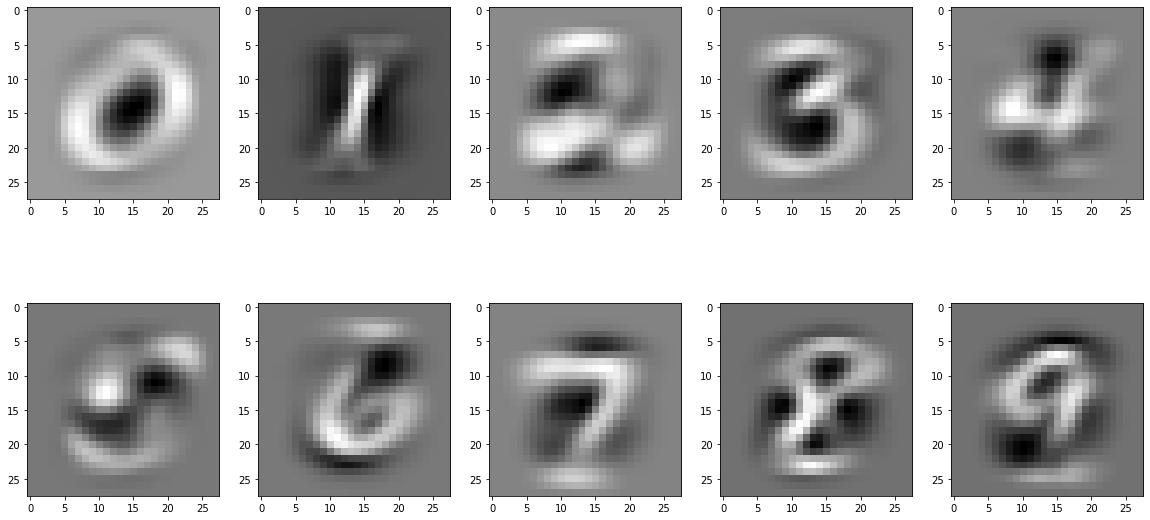

In [19]:
%%time
loss = []
batch_size = int(len(X_train_big) / 100)
for ep in range(1000):
    for _ in range(0, 100):
        X_batch = X_train_big[_ * batch_size : (_ + 1) * batch_size]
        y_batch = y_train_big[_ * batch_size : (_ + 1) * batch_size]
        NN.fit(X_batch, y_batch)
        loss.append((ep, NN.get_loss()))
    if (ep + 1) % 100 == 0:
        print('Training accuracy: ', NN.score(X_train_big, y_train_big), 'Test accuracy:', NN.score(X_test_big, y_test_big), 'Current loss:', loss[-1])
NN.print_weights()

In [20]:
NN = FullyConnectedNetwork(alpha=0.01, reg_type='l2', lambda_=0.2)
NN.add_layer((784, 64), 'ReLU')
NN.add_layer((64, 121), 'ReLU')
NN.add_layer((121, 10), 'Softmax', class_number=10)

Training accuracy:  0.12523333333333334 Test accuracy: 0.1273 Current loss: (99, 2068.297888949137)
Training accuracy:  0.20143333333333333 Test accuracy: 0.2065 Current loss: (199, 1884.9778502968422)
Training accuracy:  0.2836 Test accuracy: 0.288 Current loss: (299, 1732.3525105069298)
Training accuracy:  0.357 Test accuracy: 0.3605 Current loss: (399, 1598.732032658128)
Training accuracy:  0.41696666666666665 Test accuracy: 0.4221 Current loss: (499, 1479.1241343160516)
Training accuracy:  0.46416666666666667 Test accuracy: 0.4706 Current loss: (599, 1370.697358671245)
Training accuracy:  0.5034333333333333 Test accuracy: 0.511 Current loss: (699, 1271.8026457883775)
Training accuracy:  0.5364666666666666 Test accuracy: 0.5435 Current loss: (799, 1181.3492541064516)
Training accuracy:  0.5633666666666667 Test accuracy: 0.5725 Current loss: (899, 1098.4800961533615)
Training accuracy:  0.5860666666666666 Test accuracy: 0.5968 Current loss: (999, 1022.4692672427734)
CPU times: user 1

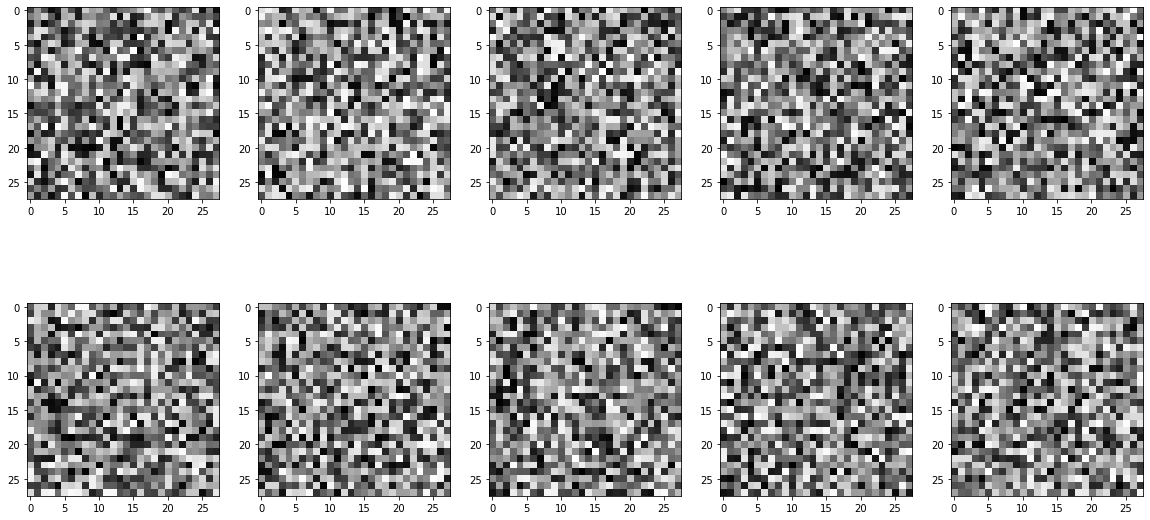

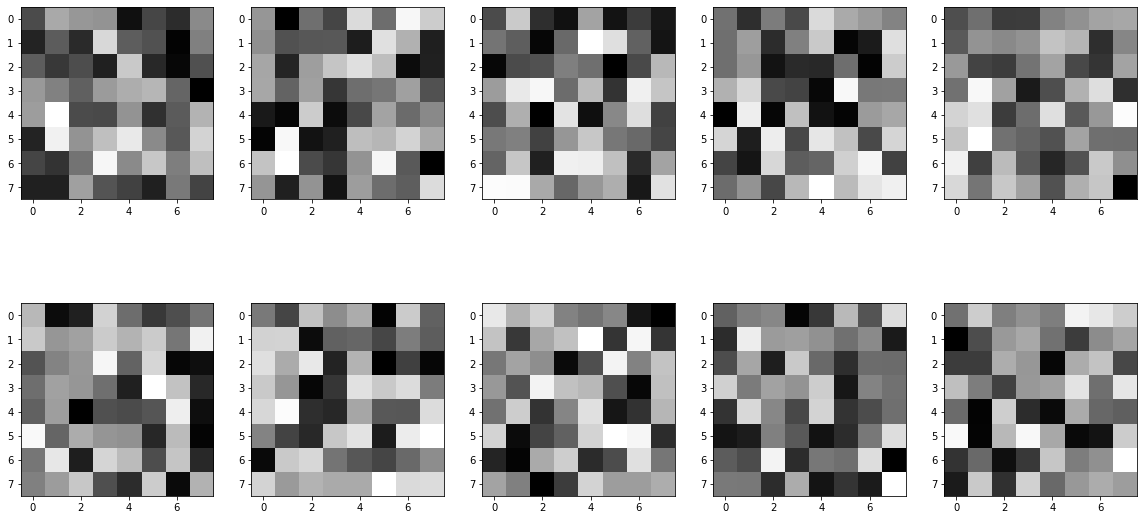

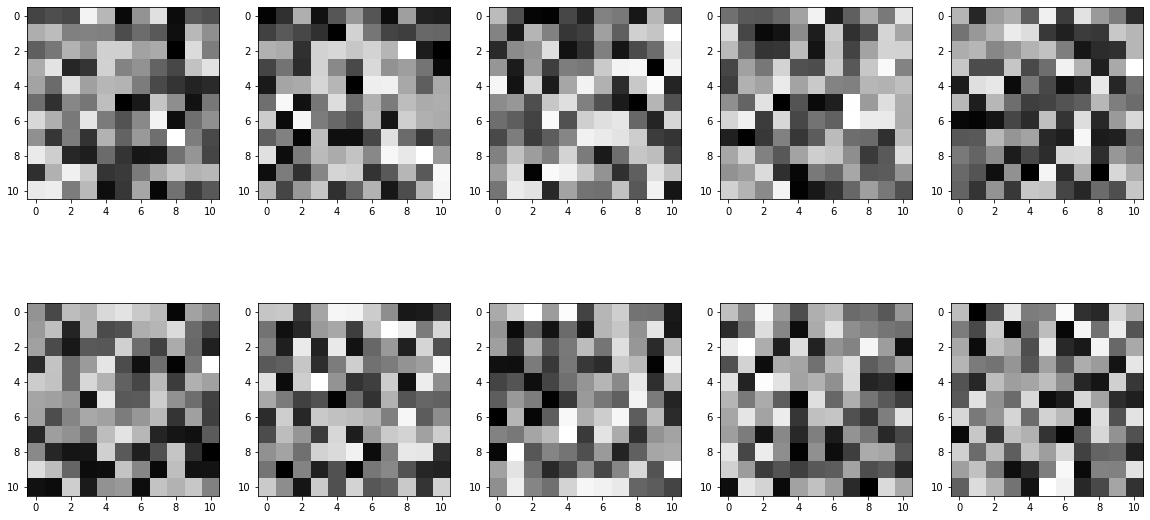

In [21]:
%%time
loss = []
for ep in range(1000):
    NN.fit(X_train_big, y_train_big)
    loss.append((ep, NN.get_loss()))
    if (ep + 1) % 100 == 0:
        print('Training accuracy: ', NN.score(X_train_big, y_train_big), 'Test accuracy:', NN.score(X_test_big, y_test_big), 'Current loss:', loss[-1])
NN.print_weights()

Training accuracy:  0.6057666666666667 Test accuracy: 0.6147 Current loss: (99, 952.685427800451)
Training accuracy:  0.62425 Test accuracy: 0.6316 Current loss: (199, 888.5665449876235)
Training accuracy:  0.6399333333333334 Test accuracy: 0.6483 Current loss: (299, 829.6141750786624)
Training accuracy:  0.6531833333333333 Test accuracy: 0.6596 Current loss: (399, 775.3823545419978)
Training accuracy:  0.6647166666666666 Test accuracy: 0.6739 Current loss: (499, 725.4685722881743)
Training accuracy:  0.6747333333333333 Test accuracy: 0.6845 Current loss: (599, 679.5099431006425)
Training accuracy:  0.6835 Test accuracy: 0.6943 Current loss: (699, 637.1785434822743)
Training accuracy:  0.6917833333333333 Test accuracy: 0.7013 Current loss: (799, 598.1749231201595)
Training accuracy:  0.6991 Test accuracy: 0.7082 Current loss: (899, 562.2276819552957)
Training accuracy:  0.70525 Test accuracy: 0.7117 Current loss: (999, 529.0900581682178)


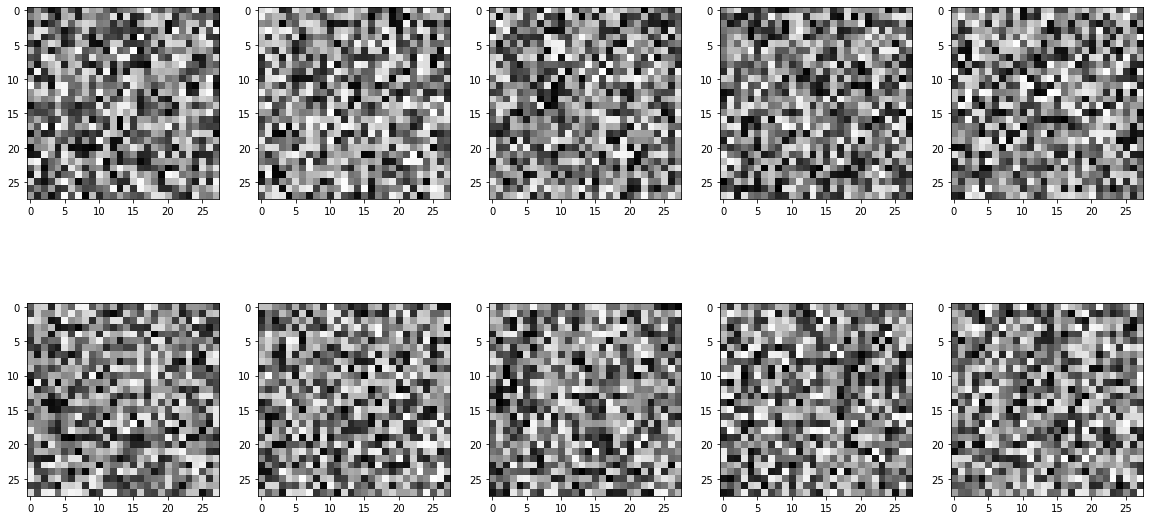

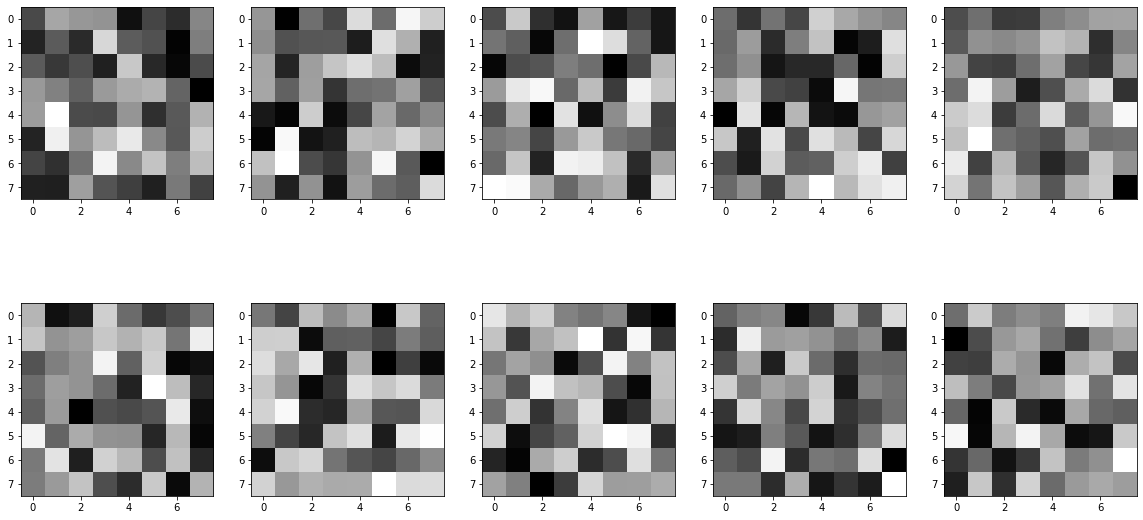

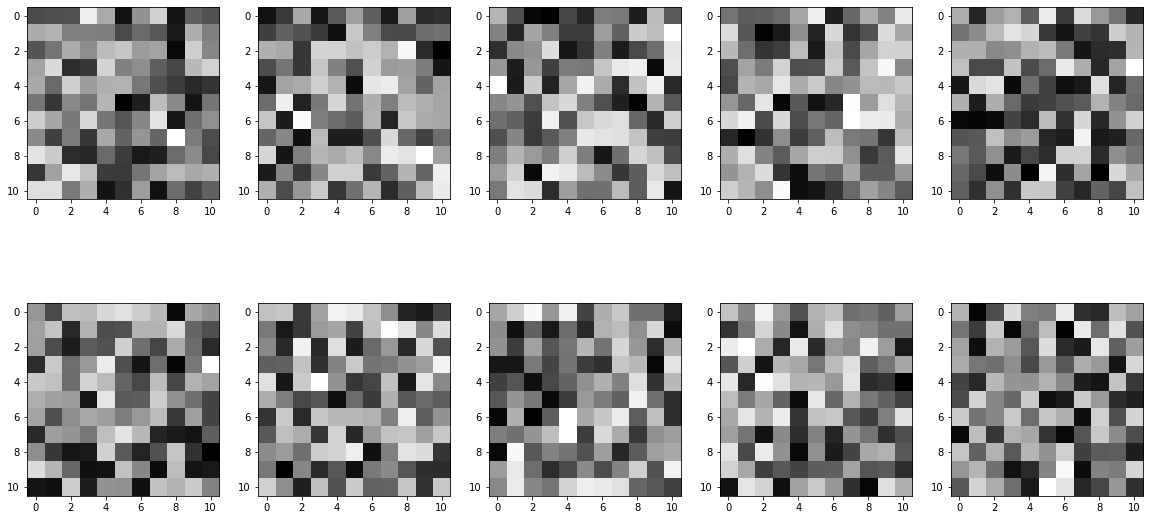

In [22]:
for ep in range(1000):
    NN.fit(X_train_big, y_train_big)
    loss.append((ep, NN.get_loss()))
    if (ep + 1) % 100 == 0:
        print('Training accuracy: ', NN.score(X_train_big, y_train_big), 'Test accuracy:', NN.score(X_test_big, y_test_big), 'Current loss:', loss[-1])
NN.print_weights()


In [29]:
alpha = 0.1
NN = FullyConnectedNetwork(alpha=alpha, reg_type='l2', lambda_=0.02)
NN.add_layer((784, 121), 'ReLU')
NN.add_layer((121, 10), 'Softmax', class_number=10)


In [30]:
%%time
loss = []
batch_size = int(len(X_train_big) / 100)
alpha = 0.1
for ep in range(1000):
    for _ in range(0, 100):
        X_batch = X_train_big[_ * batch_size : (_ + 1) * batch_size]
        y_batch = y_train_big[_ * batch_size : (_ + 1) * batch_size]
        NN.fit(X_batch, y_batch)
        loss.append((ep, NN.get_loss()))
    if (ep + 1) % 10 == 0:
        print('Training accuracy: ', NN.score(X_train_big, y_train_big), 'Test accuracy:', NN.score(X_test_big, y_test_big), 'Current loss:', loss[-1])
    if (ep + 1) % 100 == 0:
        alpha = alpha / 5
        NN.change_alpha(alpha)
NN.print_weights()


Training accuracy:  0.8889 Test accuracy: 0.8971 Current loss: (9, 111.33779002289009)
Training accuracy:  0.8905833333333333 Test accuracy: 0.8993 Current loss: (19, 111.57309154482157)
Training accuracy:  0.8914833333333333 Test accuracy: 0.9007 Current loss: (29, 111.5851189709206)
Training accuracy:  0.89215 Test accuracy: 0.9015 Current loss: (39, 111.58115060469639)
Training accuracy:  0.8924333333333333 Test accuracy: 0.9018 Current loss: (49, 111.573254079988)
Training accuracy:  0.8925166666666666 Test accuracy: 0.9015 Current loss: (59, 111.55352823617888)
Training accuracy:  0.8926333333333333 Test accuracy: 0.9016 Current loss: (69, 111.52373461810339)
Training accuracy:  0.8926333333333333 Test accuracy: 0.9017 Current loss: (79, 111.48990695201584)
Training accuracy:  0.89275 Test accuracy: 0.9016 Current loss: (89, 111.46342664687185)
Training accuracy:  0.8929333333333334 Test accuracy: 0.9015 Current loss: (99, 111.43972657442205)
Training accuracy:  0.8953333333333333

KeyboardInterrupt: 

0.8954

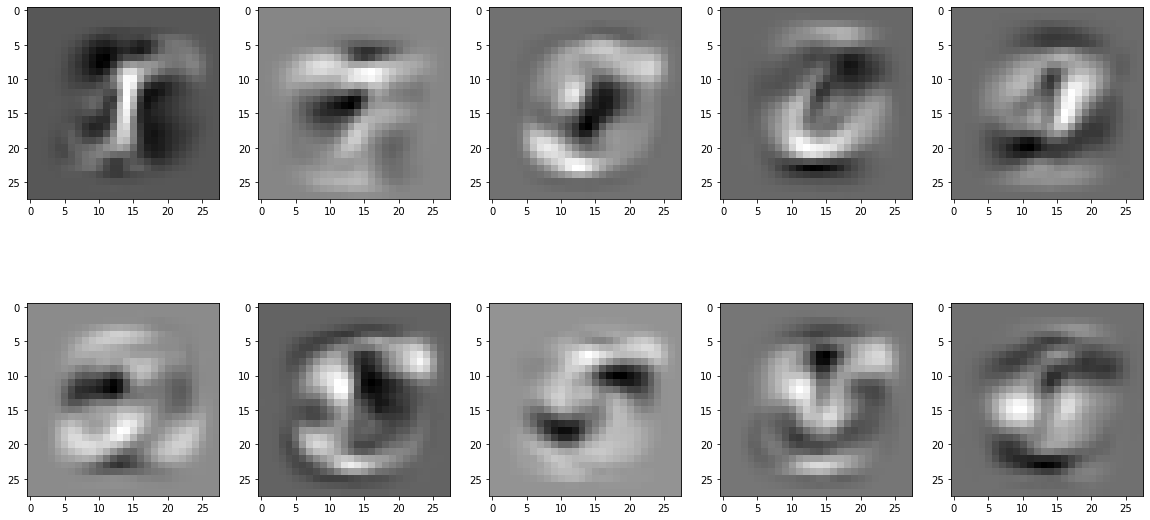

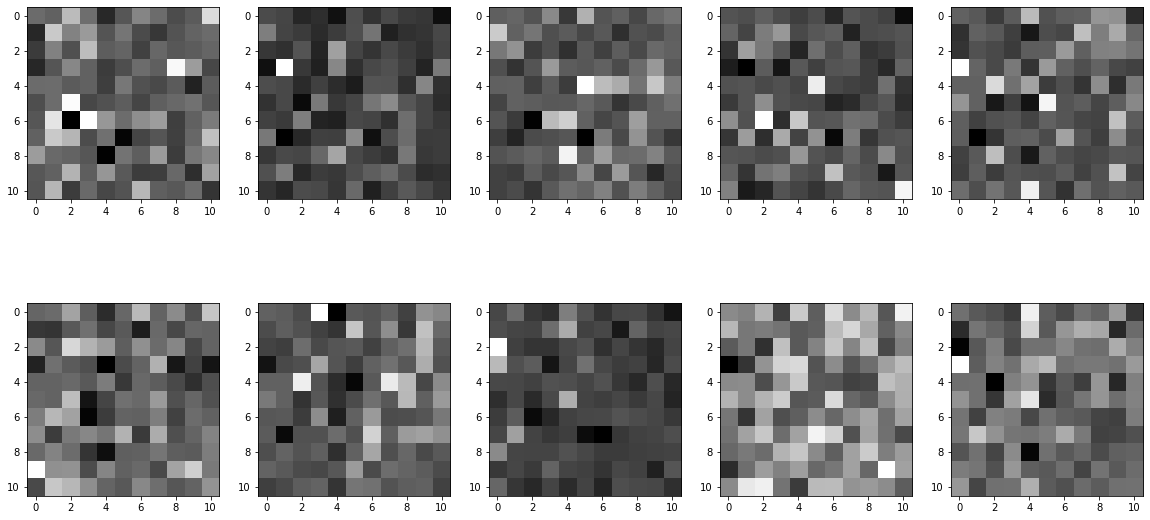

In [31]:
NN.print_weights()
NN.score(X_train_big, y_train_big)